In [167]:
%matplotlib inline

import gmaps
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt

from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)
gmaps.figure()

Figure(layout=FigureLayout(height='420px'))

In [168]:
crashes = pd.read_csv("Resources/Traffic_Crashes_-_Crashes_2017-present.csv", low_memory=False)
crashes.head()

,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,JC193526,NaN,3/21/2019 0:50,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,0,5,3,41.808203,-87.704125,POINT (-87.704125461348 41.808203053915)
1,JC193531,NaN,3/21/2019 0:49,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,...,0.0,0.0,1.0,0.0,0,5,3,41.791284,-87.741697,POINT (-87.741696867821 41.791283705634)
2,JC193482,NaN,3/20/2019 22:35,5,TRAFFIC SIGNAL,UNKNOWN,RAIN,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,RAMP,...,0.0,0.0,1.0,0.0,22,4,3,41.884390,-87.629599,POINT (-87.629599098569 41.884389603817)
3,JC193506,NaN,3/20/2019 22:00,30,NO CONTROLS,NO CONTROLS,RAIN,DARKNESS,REAR END,NOT DIVIDED,...,0.0,0.0,2.0,0.0,22,4,3,41.685684,-87.603466,POINT (-87.603466225555 41.685683631223)
4,JC193468,NaN,3/20/2019 22:00,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,...,0.0,0.0,2.0,0.0,22,4,3,41.910866,-87.649665,POINT (-87.649664933008 41.910865686084)


In [169]:
# crashes["CRASH_DATE"].min()
crashes.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,225631.000000,1.478540e+05,225631.000000,225631.000000,225104.000000,224651.000000,224651.000000,224651.000000,224651.000000,224651.000000,224651.000000,224651.0,225631.000000,225631.000000,225631.000000,224734.000000,224734.000000
mean,28.255905,1.704561e+01,3596.120954,1261.457473,2.023540,0.172107,0.001006,0.019154,0.094288,0.057658,2.022110,0.0,13.130962,4.119908,6.438712,41.859790,-87.674064
std,6.629212,3.435941e+03,2803.602162,709.865065,0.428493,0.532311,0.034782,0.161130,0.391660,0.303875,1.178442,0.0,5.474573,1.968728,3.590959,0.329580,0.669363
min,0.000000,0.000000e+00,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.933994
25%,30.000000,2.000000e+00,1200.000000,724.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,3.000000,41.790613,-87.721502
50%,30.000000,2.000000e+00,3131.000000,1221.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.879495,-87.673883
75%,30.000000,4.000000e+00,5500.000000,1831.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,10.000000,41.926959,-87.634074
max,70.000000,1.191625e+06,13799.000000,2535.000000,18.000000,21.000000,3.000000,7.000000,21.000000,10.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


In [170]:
# crash_location = crashes.loc[:,"LATITUDE":"LONGITUDE"]
# crashes.dropna(how='any', inplace=True)
crashes.rename(columns={"LATITUDE": "Lat", "LONGITUDE":"Lng"}, inplace=True)
crashes["Region ID"] = ""
crashes.head()

,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,Lat,Lng,LOCATION,Region ID
0,JC193526,NaN,3/21/2019 0:50,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,2.0,0.0,0,5,3,41.808203,-87.704125,POINT (-87.704125461348 41.808203053915),
1,JC193531,NaN,3/21/2019 0:49,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,...,0.0,1.0,0.0,0,5,3,41.791284,-87.741697,POINT (-87.741696867821 41.791283705634),
2,JC193482,NaN,3/20/2019 22:35,5,TRAFFIC SIGNAL,UNKNOWN,RAIN,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,RAMP,...,0.0,1.0,0.0,22,4,3,41.884390,-87.629599,POINT (-87.629599098569 41.884389603817),
3,JC193506,NaN,3/20/2019 22:00,30,NO CONTROLS,NO CONTROLS,RAIN,DARKNESS,REAR END,NOT DIVIDED,...,0.0,2.0,0.0,22,4,3,41.685684,-87.603466,POINT (-87.603466225555 41.685683631223),
4,JC193468,NaN,3/20/2019 22:00,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,...,0.0,2.0,0.0,22,4,3,41.910866,-87.649665,POINT (-87.649664933008 41.910865686084),


In [171]:
crashes.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,Lat,Lng
count,225631.000000,1.478540e+05,225631.000000,225631.000000,225104.000000,224651.000000,224651.000000,224651.000000,224651.000000,224651.000000,224651.000000,224651.0,225631.000000,225631.000000,225631.000000,224734.000000,224734.000000
mean,28.255905,1.704561e+01,3596.120954,1261.457473,2.023540,0.172107,0.001006,0.019154,0.094288,0.057658,2.022110,0.0,13.130962,4.119908,6.438712,41.859790,-87.674064
std,6.629212,3.435941e+03,2803.602162,709.865065,0.428493,0.532311,0.034782,0.161130,0.391660,0.303875,1.178442,0.0,5.474573,1.968728,3.590959,0.329580,0.669363
min,0.000000,0.000000e+00,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.933994
25%,30.000000,2.000000e+00,1200.000000,724.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,3.000000,41.790613,-87.721502
50%,30.000000,2.000000e+00,3131.000000,1221.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.879495,-87.673883
75%,30.000000,4.000000e+00,5500.000000,1831.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,10.000000,41.926959,-87.634074
max,70.000000,1.191625e+06,13799.000000,2535.000000,18.000000,21.000000,3.000000,7.000000,21.000000,10.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


In [172]:
target_url = (f"https://maps.googleapis.com/maps/api/geocode/json?address=Chicago&key={gkey}")
geo_data = requests.get(target_url).json()
print(json.dumps(geo_data, indent=4, sort_keys=True))

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "Chicago",
                    "short_name": "Chicago",
                    "types": [
                        "locality",
                        "political"
                    ]
                },
                {
                    "long_name": "Cook County",
                    "short_name": "Cook County",
                    "types": [
                        "administrative_area_level_2",
                        "political"
                    ]
                },
                {
                    "long_name": "Illinois",
                    "short_name": "IL",
                    "types": [
                        "administrative_area_level_1",
                        "political"
                    ]
                },
                {
                    "long_name": "United States",
                    "short_name": "US",
                    "types": [
 

In [173]:
lat_min = geo_data['results'][0]['geometry']['bounds']['southwest']['lat']
lat_max = geo_data['results'][0]['geometry']['bounds']['northeast']['lat']
lng_min = geo_data['results'][0]['geometry']['bounds']['southwest']['lng']
lng_max = geo_data['results'][0]['geometry']['bounds']['northeast']['lng']
print(f"Illinois spans latitude {lat_min} to {lat_max}.")
print(f"Illinois spans longitude {lng_min} to {lng_max}.")
print("We will need to discard any errant data that falls outside these bounds.")

Illinois spans latitude 41.6443349 to 42.023131.
Illinois spans longitude -87.9402669 to -87.52366099999999.
We will need to discard any errant data that falls outside these bounds.


In [174]:
i = 0
for index, row in crashes.iterrows():
    if (crashes["Lat"][index] < lat_min) | (crashes["Lat"][index] > lat_max) | (np.isnan(crashes["Lat"][index])) | (crashes["Lng"][index] < lng_min) | (crashes["Lng"][index] > lng_max) | (np.isnan(crashes["Lng"][index])):
        print(f"Out of bounds: lat/lng {crashes['Lat'][index]}, {crashes['Lng'][index]}. Dropping record...")
        crashes.drop(index, inplace=True)
        i += 1
print(f"Cleaning complete: {i} rows were dropped due to lat/lng outside bounds.")

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng 0.0, 0.0. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bounds: lat/lng nan, nan. Dropping record...
Out of bound

In [175]:
crashes.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,Lat,Lng
count,224721.000000,1.472080e+05,224721.000000,224721.000000,224199.000000,223748.000000,223748.000000,223748.000000,223748.000000,223748.000000,223748.000000,223748.0,224721.000000,224721.000000,224721.000000,224721.000000,224721.000000
mean,28.250911,1.710537e+01,3595.402544,1262.533270,2.023711,0.171881,0.001010,0.019151,0.094110,0.057609,2.021712,0.0,13.132555,4.120171,6.438708,41.862211,-87.679136
std,6.612784,3.443472e+03,2801.136403,709.828105,0.428596,0.531908,0.034852,0.161100,0.391118,0.303777,1.177617,0.0,5.473265,1.968664,3.590564,0.085184,0.058063
min,0.000000,0.000000e+00,1.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,41.644670,-87.933994
25%,30.000000,2.000000e+00,1200.000000,725.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,3.000000,41.790637,-87.721508
50%,30.000000,2.000000e+00,3131.000000,1221.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.879495,-87.673888
75%,30.000000,4.000000e+00,5500.000000,1831.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,10.000000,41.926969,-87.634080
max,70.000000,1.191625e+06,13799.000000,2535.000000,18.000000,21.000000,3.000000,7.000000,21.000000,10.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,-87.524587


In [176]:
regions = pd.read_csv("Resources/Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Regions.csv", low_memory=False)
regions.head()
regions.describe()

,REGION_ID,WEST,EAST,SOUTH,NORTH,CURRENT_SPEED
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,15.000000,-87.701910,-87.642355,41.824520,41.867706,22.871379
std,8.514693,0.068858,0.063614,0.099126,0.096047,4.484596
min,1.000000,-87.846210,-87.747456,41.644139,41.677477,12.270000
25%,8.000000,-87.747456,-87.674590,41.764066,41.822792,20.450000
50%,15.000000,-87.685372,-87.646438,41.822792,41.866129,23.180000
75%,22.000000,-87.647208,-87.606334,41.909269,41.931841,25.230000
max,29.000000,-87.584845,-87.524436,41.997946,42.026444,32.730000


In [177]:
region_location = regions.loc[:," REGION_ID":" NORTH"]
region_location.head()

,REGION_ID,WEST,EAST,SOUTH,NORTH
0,25,-87.747456,-87.662508,41.677477,41.728472
1,21,-87.606334,-87.566260,41.764066,41.822792
2,9,-87.775947,-87.747456,41.866129,41.909269
3,18,-87.747456,-87.683730,41.764066,41.822792
4,8,-87.674590,-87.619112,41.910561,41.960669


In [127]:
counter = 0
for index, row in crashes.iterrows():
    for index2, row2 in region_location.iterrows():
        if ((crashes["Lat"][index] < region_location[" NORTH"][index2]) & (crashes["Lat"][index] > region_location[" SOUTH"][index2]) & (crashes["Lng"][index] > region_location[" WEST"][index2]) & (crashes["Lng"][index] < region_location[" EAST"][index2])):
            crashes["Region ID"][index] = region_location[" REGION_ID"][index2]
            counter += 1
            if counter % 1000 == 0:
                print(f"{counter} records matched...")
crashes.head()

C:\Users\Robert\AppData\Local\Continuum\anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


1000 records matched...
2000 records matched...
3000 records matched...
4000 records matched...
5000 records matched...
6000 records matched...
7000 records matched...
8000 records matched...
9000 records matched...
10000 records matched...
11000 records matched...
12000 records matched...
13000 records matched...
14000 records matched...
15000 records matched...
16000 records matched...
17000 records matched...
18000 records matched...
19000 records matched...
20000 records matched...
21000 records matched...
22000 records matched...
23000 records matched...
24000 records matched...
25000 records matched...
26000 records matched...
27000 records matched...
28000 records matched...
29000 records matched...
30000 records matched...
31000 records matched...
32000 records matched...
33000 records matched...
34000 records matched...
35000 records matched...
36000 records matched...
37000 records matched...
38000 records matched...
39000 records matched...
40000 records matched...
41000 rec

,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,Lat,Lng,LOCATION,Region ID
0,JC193526,NaN,3/21/2019 0:50,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,2.0,0.0,0,5,3,41.808203,-87.704125,POINT (-87.704125461348 41.808203053915),18
1,JC193531,NaN,3/21/2019 0:49,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,...,0.0,1.0,0.0,0,5,3,41.791284,-87.741697,POINT (-87.741696867821 41.791283705634),18
2,JC193482,NaN,3/20/2019 22:35,5,TRAFFIC SIGNAL,UNKNOWN,RAIN,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,RAMP,...,0.0,1.0,0.0,22,4,3,41.884390,-87.629599,POINT (-87.629599098569 41.884389603817),13
3,JC193506,NaN,3/20/2019 22:00,30,NO CONTROLS,NO CONTROLS,RAIN,DARKNESS,REAR END,NOT DIVIDED,...,0.0,2.0,0.0,22,4,3,41.685684,-87.603466,POINT (-87.603466225555 41.685683631223),26
4,JC193468,NaN,3/20/2019 22:00,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,...,0.0,2.0,0.0,22,4,3,41.910866,-87.649665,POINT (-87.649664933008 41.910865686084),8


In [128]:
crashes.to_csv("Resources/Crashes_w_Region.csv")

In [178]:
crashes_clean = pd.read_csv("Resources/Crashes_w_Region_cleaned.csv", low_memory=False)

crash_final = crashes_clean['Region ID'].value_counts().to_frame()
crash_final.rename(columns={'Region ID': "crash_count"}, inplace=True)
crash_final

,crash_count
18,15231
11,12721
10,12704
5,12253
8,11375
13,11287
3,10364
23,9771
6,9638
7,9184


In [133]:
crash_final.to_csv("Resources/Crashes_Region.csv")

In [179]:
rl_cams = pd.read_csv("Resources/Red_Light_Camera_Locations.csv", low_memory=False)
rl_cams.head()

,INTERSECTION,FIRST APPROACH,SECOND APPROACH,THIRD APPROACH,GO LIVE DATE,LATITUDE,LONGITUDE,LOCATION
0,Pulaski-Diversey,SB,NB,NaN,05/15/2009,41.931791,-87.726979,"(41.931791, -87.726979)"
1,Pulaski-Foster,SB,WB,NaN,10/18/2007,41.975532,-87.728234,"(41.975532, -87.728234)"
2,Cicero-Fullerton,SB,WB,NaN,02/25/2006,41.924237,-87.746302,"(41.924237, -87.746302)"
3,Harlem-Belmont,NB,WB,NaN,06/18/2007,41.937997,-87.806746,"(41.937997, -87.806746)"
4,Narragansett-Fullerton,EB,WB,NaN,11/14/2008,41.923676,-87.785441,"(41.923676, -87.785441)"


In [180]:
rl_location = rl_cams.loc[:,"LATITUDE":"LONGITUDE"]
rl_location["LATITUDE"].dropna(how='any', inplace=True)
rl_location["LONGITUDE"].dropna(how='any', inplace=True)
rl_location.rename(columns={"LATITUDE": "Lat", "LONGITUDE":"Lng"}, inplace=True)
rl_location["Region ID"] = ""
rl_location.head()

,Lat,Lng,Region ID
0,41.931791,-87.726979,
1,41.975532,-87.728234,
2,41.924237,-87.746302,
3,41.937997,-87.806746,
4,41.923676,-87.785441,


In [181]:
for index, row in rl_location.iterrows():
    for index2, row2 in region_location.iterrows():
        if ((rl_location["Lat"][index] < region_location[" NORTH"][index2]) & (rl_location["Lat"][index] > region_location[" SOUTH"][index2]) & (rl_location["Lng"][index] > region_location[" WEST"][index2]) & (rl_location["Lng"][index] < region_location[" EAST"][index2])):
            rl_location["Region ID"][index] = region_location[" REGION_ID"][index2]
rl_location.head()

C:\Users\Robert\AppData\Local\Continuum\anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Lat,Lng,Region ID
0,41.931791,-87.726979,7
1,41.975532,-87.728234,3
2,41.924237,-87.746302,7
3,41.937997,-87.806746,5
4,41.923676,-87.785441,5


In [182]:
rl_final = rl_location['Region ID'].value_counts().to_frame()
rl_final.rename(columns={'Region ID': "red_light_camera_count"}, inplace=True)
rl_final

,red_light_camera_count
5,15
7,14
6,13
18,12
10,10
3,10
11,9
8,8
2,7
14,6


In [107]:
rl_final.to_csv("Resources/Red_Light_Cam_Region.csv")

In [183]:
speed_cams = pd.read_csv("Resources/Speed_Camera_Locations.csv", low_memory=False)
speed_cams.head()

,ADDRESS,FIRST APPROACH,SECOND APPROACH,GO-LIVE DATE,LATITUDE,LONGITUDE,LOCATION
0,3843 W 111th (Speed Camera),EB,WB,01/13/2014,41.691202,-87.717211,"(41.69120239624487, -87.71721139909997)"
1,19 W Chicago Ave (Speed Camera),WB,NaN,04/29/2014,41.896556,-87.629026,"(41.89655610710888, -87.62902590382873)"
2,2445 W 51st St (Speed Camera),EB,NaN,02/24/2014,41.801013,-87.686071,"(41.801012880525555, -87.68607060493738)"
3,7739 S Western (Speed Camera),NB,NaN,12/18/2013,41.752629,-87.682765,"(41.752629293489285, -87.68276525603093)"
4,3832 W 79th St (Speed Camera),EB,NaN,02/10/2014,41.749715,-87.719599,"(41.749715176851936, -87.71959877920995)"


In [184]:
speed_location = speed_cams.loc[:,"LATITUDE":"LONGITUDE"]
speed_location["LATITUDE"].dropna(how='any', inplace=True)
speed_location["LONGITUDE"].dropna(how='any', inplace=True)
speed_location.rename(columns={"LATITUDE": "Lat", "LONGITUDE":"Lng"}, inplace=True)
speed_location["Region ID"] = ""
speed_location.head()

,Lat,Lng,Region ID
0,41.691202,-87.717211,
1,41.896556,-87.629026,
2,41.801013,-87.686071,
3,41.752629,-87.682765,
4,41.749715,-87.719599,


In [185]:
for index, row in speed_location.iterrows():
    for index2, row2 in region_location.iterrows():
        if ((speed_location["Lat"][index] < region_location[" NORTH"][index2]) & (speed_location["Lat"][index] > region_location[" SOUTH"][index2]) & (speed_location["Lng"][index] > region_location[" WEST"][index2]) & (speed_location["Lng"][index] < region_location[" EAST"][index2])):
            speed_location["Region ID"][index] = region_location[" REGION_ID"][index2]
speed_location.head()

C:\Users\Robert\AppData\Local\Continuum\anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Lat,Lng,Region ID
0,41.691202,-87.717211,25
1,41.896556,-87.629026,12
2,41.801013,-87.686071,18
3,41.752629,-87.682765,22
4,41.749715,-87.719599,22


In [186]:
speed_final = speed_location['Region ID'].value_counts().to_frame()
speed_final.rename(columns={'Region ID': "speed_camera_count"}, inplace=True)
speed_final

,speed_camera_count
18,22
5,16
10,14
3,10
6,10
11,8
22,8
8,8
15,7
2,7


In [108]:
speed_final.to_csv("Resources/Speed_Cam_Region.csv")

In [187]:
merged_1 = crash_final.merge(rl_final, how='outer', left_index=True, right_index=True)
merged_df = merged_1.merge(speed_final, how='outer', left_index=True, right_index=True)
merged_df.fillna(0,inplace=True)
merged_df

,crash_count,red_light_camera_count,speed_camera_count
1,5106,2.0,1.0
2,7593,7.0,7.0
3,10364,10.0,10.0
4,5864,5.0,3.0
5,12253,15.0,16.0
6,9638,13.0,10.0
7,9184,14.0,3.0
8,11375,8.0,8.0
9,5991,3.0,3.0
10,12704,10.0,14.0


In [156]:
merged_df.to_csv("Resources/Region_Summary.csv")
sort_merged_df = merged_df.sort_values(by='crash_count',ascending=False)
sort_merged_df.head()

,crash_count,red_light_camera_count,speed_camera_count
18,15231,12.0,22.0
11,12721,9.0,8.0
10,12704,10.0,14.0
5,12253,15.0,16.0
8,11375,8.0,8.0


Text(0, 0.5, 'Traffic Crashes')

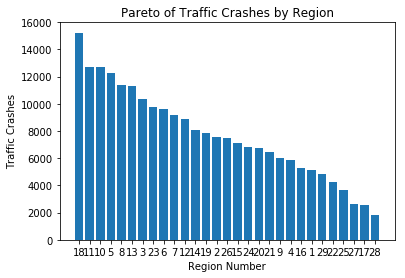

In [166]:
x = sort_merged_df.index.values.astype(str)
y = sort_merged_df['crash_count']
plt.bar(x,y)
plt.title("Pareto of Traffic Crashes by Region")
plt.xlabel("Region Number")
plt.ylabel("Traffic Crashes")

# plt.savefig("Crashes_vs_Red_Light_Cams.png")

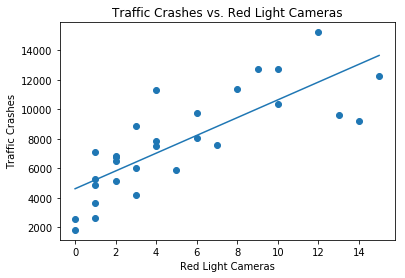

In [140]:
x = merged_df['red_light_camera_count']
y = merged_df['crash_count']
plt.scatter(x,y)
plt.title("Traffic Crashes vs. Red Light Cameras")
plt.xlabel("Red Light Cameras")
plt.ylabel("Traffic Crashes")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

plt.savefig("Crashes_vs_Red_Light_Cams.png")

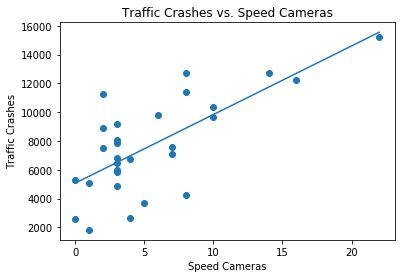

In [147]:
x = merged_df['speed_camera_count']
y = merged_df['crash_count']
plt.scatter(x,y)
plt.title("Traffic Crashes vs. Speed Cameras")
plt.xlabel("Speed Cameras")
plt.ylabel("Traffic Crashes")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

plt.savefig("Crashes_vs_Speed_Cams.png")

In [188]:
merged_df.head()

,crash_count,red_light_camera_count,speed_camera_count
1,5106,2.0,1.0
2,7593,7.0,7.0
3,10364,10.0,10.0
4,5864,5.0,3.0
5,12253,15.0,16.0


In [192]:
merged_df2 = merged_df.loc[:,'red_light_camera_count':'speed_camera_count']
merged_df2.head()

,red_light_camera_count,speed_camera_count
1,2.0,1.0
2,7.0,7.0
3,10.0,10.0
4,5.0,3.0
5,15.0,16.0


In [193]:
merged_df2['total_cameras'] = merged_df2['red_light_camera_count'] + merged_df2['speed_camera_count']
merged_df2.head()

,red_light_camera_count,speed_camera_count,total_cameras
1,2.0,1.0,3.0
2,7.0,7.0,14.0
3,10.0,10.0,20.0
4,5.0,3.0,8.0
5,15.0,16.0,31.0


In [226]:
sort_merged_df2 = merged_df2.sort_values(['total_cameras','red_light_camera_count'], ascending=[False, False])
sort_merged_df2.head()

,red_light_camera_count,speed_camera_count,total_cameras
18,12.0,22.0,34.0
5,15.0,16.0,31.0
10,10.0,14.0,24.0
6,13.0,10.0,23.0
3,10.0,10.0,20.0


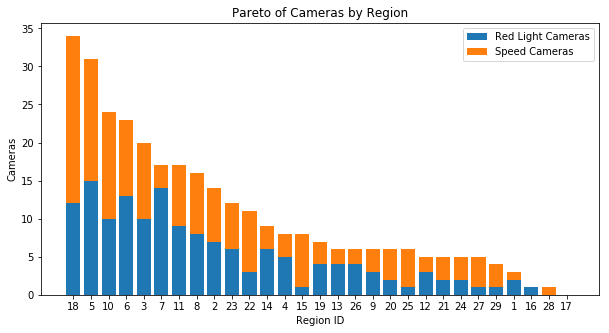

In [227]:
x = sort_merged_df2.index.values.astype(str)
y1 = sort_merged_df2['red_light_camera_count']
y2 = sort_merged_df2['speed_camera_count']

p1, p2 = plt.subplots(figsize=(10, 5))

p1 = plt.bar(x, y1)
p2 = plt.bar(x, y2, bottom=y1)
# p1.figure(figsize=(10, 5))
plt.ylabel('Cameras')
plt.xlabel('Region ID')
plt.title('Pareto of Cameras by Region')
plt.xticks(x)
plt.legend((p1[0], p2[0]), ('Red Light Cameras', 'Speed Cameras'))
plt.savefig("Cameras_by_Region_Pareto.png")

In [245]:
normalized = pd.read_csv("Resources/Region_Summary.csv")
normalized.head()

,Unnamed: 0,crash_count,red_light_camera_count,speed_camera_count
0,1,5106,2.0,1.0
1,2,7593,7.0,7.0
2,3,10364,10.0,10.0
3,4,5864,5.0,3.0
4,5,12253,15.0,16.0


In [230]:
congestion_df = pd.read_csv("Resources/Congestion_by_Region.csv")
congestion_df.head()

,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,congestion
0,1,22.179399,347.628862,21.760622,51.643062
1,2,31.168334,460.184192,27.399208,39.112871
2,3,47.428873,728.835985,22.058373,50.981392
3,4,33.396979,514.981728,20.647313,54.117083
4,5,48.083678,845.004620,23.378937,48.046807


In [246]:
normalized['congestion'] = congestion_df['congestion'] / 100
normalized.rename(columns={"Unnamed: 0":"Region ID"},inplace=True)
normalized.set_index('Region ID',inplace=True)
normalized.head()

,crash_count,red_light_camera_count,speed_camera_count,congestion
Region ID,,,,
1,5106,2.0,1.0,0.516431
2,7593,7.0,7.0,0.391129
3,10364,10.0,10.0,0.509814
4,5864,5.0,3.0,0.541171
5,12253,15.0,16.0,0.480468


In [267]:
normalized

,crash_count,red_light_camera_count,speed_camera_count,congestion,crash_normalized,rl_normalized,speed_normalized
Region ID,,,,,,,
1,5106,2.0,1.0,0.516431,2636.894722,3.872737,1.936369
2,7593,7.0,7.0,0.391129,2969.840325,17.896922,17.896922
3,10364,10.0,10.0,0.509814,5283.711511,19.615000,19.615000
4,5864,5.0,3.0,0.541171,3173.425731,9.239227,5.543536
5,12253,15.0,16.0,0.480468,5887.175266,31.219556,33.300860
6,9638,13.0,10.0,0.518801,5000.207433,25.057760,19.275200
7,9184,14.0,3.0,0.530418,4871.356168,26.394293,5.655920
8,11375,8.0,8.0,0.544906,6198.309007,14.681424,14.681424
9,5991,3.0,3.0,0.473257,2835.283658,6.339048,6.339048


In [268]:
normalized['crash_normalized'] = normalized['crash_count'] / normalized['congestion']
normalized['rl_normalized'] = normalized['red_light_camera_count'] / normalized['congestion']
normalized['speed_normalized'] = normalized['speed_camera_count'] / normalized['congestion']
normalized['congestion'].min()

0.24487169973740566

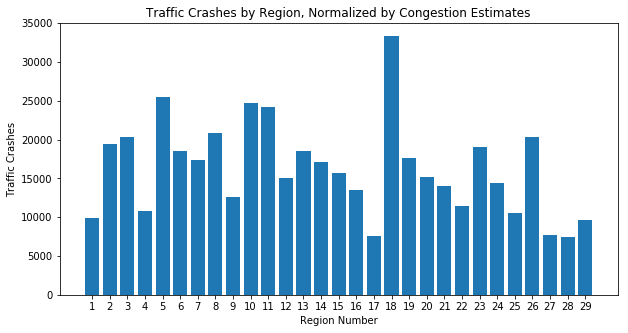

In [274]:
fig, ax = plt.subplots(figsize=(10, 5))

x = normalized.index.values
y = normalized['crash_normalized']

ax.bar(x,y)
ax.set_title("Traffic Crashes by Region, Normalized by Congestion Estimates")
ax.set_xlabel("Region Number")
ax.set_ylabel("Traffic Crashes")
ax.set_xticks(normalized.index.values)


# plt.savefig("Crashes_vs_Red_Light_Cams.png")
print("")

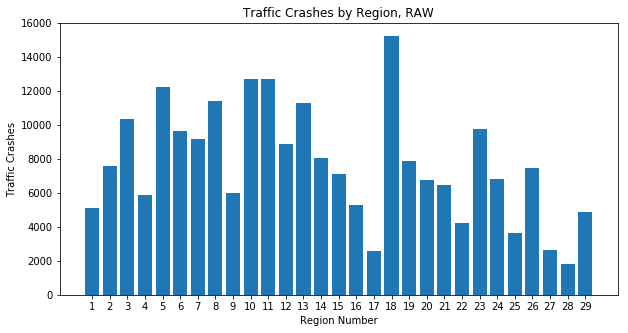

In [271]:
fig, ax = plt.subplots(figsize=(10, 5))

x = normalized.index.values
y = normalized['crash_count']

ax.bar(x,y)
ax.set_title("Traffic Crashes by Region, RAW")
ax.set_xlabel("Region Number")
ax.set_ylabel("Traffic Crashes")
ax.set_xticks(normalized.index.values)
print("")